In [1]:
from bs4 import BeautifulSoup
import requests
import os
import datetime
import pandas as pd

In [2]:
# Instalación de Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
#Obtener las versiones de spark la pagina web
url = 'https://downloads.apache.org/spark/'
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)

In [4]:
# read the web page and get the lastest versions available
link_files = []
for link in soup.find_all('a'):
  link_files.append(link.get('href'))
spark_link = [x for x in link_files if 'spark' in x]  
ver_spark = spark_link[1][:-1] # get lastest versions of pyspark and drop remove '/' from the string
print(ver_spark)

spark-3.2.2


In [5]:
# intall the wanted version
!wget -q "https://downloads.apache.org/spark/spark-3.2.2/spark-3.2.2-bin-hadoop2.7.tgz"
!tar xf spark-3.2.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [6]:
# Set the proper enviroment
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{ver_spark}-bin-hadoop2.7"

In [7]:
!pip install databricks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install koalas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 390 kB 6.6 MB/s 


In [9]:
# import libraries
import findspark
findspark.init()

In [10]:
from datetime import datetime
from pyspark.sql import SparkSession, Window, Row, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import StorageLevel

import databricks.koalas as ks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

### Basic operations Dataframes

In [12]:
# Values for the dataframe
emp = \
  [
      (1, "AAA", "dept1", 1000),
      (2, "BBB", "dept1", 1100),
      (3, "CCC", "dept1", 3000),
      (4, "DDD", "dept1", 1500),
      (5, "EEE", "dept2", 8000),
      (6, "FFF", "dept2", 7200),
      (7, "GGG", "dept3", 7100),
      (8, "HHH", "dept3", 3700),
      (9, "III", "dept3", 4500),
      (10, "JJJ", "dept5", 3400)
  ]

dept = \
  [
      ("dept1", "Department - 1"),
      ("dept2", "Department - 2"),
      ("dept3", "Department - 3"),
      ("dept4", "Department - 4")
  ]

In [13]:
# Create Dataframe
df = spark.createDataFrame(emp, schema=['id', 'name', 'dept', 'salary'])

df_dept = spark.createDataFrame(dept, schema=['id', 'name'])

In [ ]:
df.show(5)

+---+----+-----+------+
| id|name| dept|salary|
+---+----+-----+------+
|  1| AAA|dept1|  1000|
|  2| BBB|dept1|  1100|
|  3| CCC|dept1|  3000|
|  4| DDD|dept1|  1500|
|  5| EEE|dept2|  8000|
+---+----+-----+------+
only showing top 5 rows



In [ ]:
df_dept.show()

+-----+--------------+
|   id|          name|
+-----+--------------+
|dept1|Department - 1|
|dept2|Department - 2|
|dept3|Department - 3|
|dept4|Department - 4|
+-----+--------------+



In [ ]:
# Create Dataframe from HIVE table
df_hive = spark.table('table_name')

In [ ]:
# Count number of rows
df.count(), df_dept.count()

(10, 4)

In [ ]:
# Columns of dataframe
df.columns

['id', 'name', 'dept', 'salary']

In [ ]:
# Dataframe types
df.dtypes

[('id', 'bigint'),
 ('name', 'string'),
 ('dept', 'string'),
 ('salary', 'bigint')]

In [ ]:
# Schema of dataframe
df.schema

StructType(List(StructField(id,LongType,true),StructField(name,StringType,true),StructField(dept,StringType,true),StructField(salary,LongType,true)))

In [ ]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- dept: string (nullable = true)
 |-- salary: long (nullable = true)



In [ ]:
# Select columns from dataframe
df.select("name", "dept").show()

+----+-----+
|name| dept|
+----+-----+
| AAA|dept1|
| BBB|dept1|
| CCC|dept1|
| DDD|dept1|
| EEE|dept2|
| FFF|dept2|
| GGG|dept3|
| HHH|dept3|
| III|dept3|
| JJJ|dept5|
+----+-----+



In [ ]:
# Filter rows by conditions
df.filter("dept = 'dept3'").show()

+---+----+-----+------+
| id|name| dept|salary|
+---+----+-----+------+
|  7| GGG|dept3|  7100|
|  8| HHH|dept3|  3700|
|  9| III|dept3|  4500|
+---+----+-----+------+



In [ ]:
df.filter(df.dept == 'dept3').show()

+---+----+-----+------+
| id|name| dept|salary|
+---+----+-----+------+
|  7| GGG|dept3|  7100|
|  8| HHH|dept3|  3700|
|  9| III|dept3|  4500|
+---+----+-----+------+



In [ ]:
df.filter(col('dept') == 'dept3').show()

+---+----+-----+------+
| id|name| dept|salary|
+---+----+-----+------+
|  7| GGG|dept3|  7100|
|  8| HHH|dept3|  3700|
|  9| III|dept3|  4500|
+---+----+-----+------+



In [ ]:
# Drop column from dataframe
df.drop('salary','dept').show()

+---+----+
| id|name|
+---+----+
|  1| AAA|
|  2| BBB|
|  3| CCC|
|  4| DDD|
|  5| EEE|
|  6| FFF|
|  7| GGG|
|  8| HHH|
|  9| III|
| 10| JJJ|
+---+----+



In [ ]:
# Aggregations over dataframe
df.\
  groupby('dept').\
  agg(
      count('id').alias('count'),
      max('salary').alias('max_salary'),
      min('salary').alias('min_salary'),
      avg('salary').alias('mean_salary')
  ).show()

+-----+-----+----------+----------+-----------+
| dept|count|max_salary|min_salary|mean_salary|
+-----+-----+----------+----------+-----------+
|dept1|    4|      3000|      1000|     1650.0|
|dept2|    2|      8000|      7200|     7600.0|
|dept5|    1|      3400|      3400|     3400.0|
|dept3|    3|      7100|      3700|     5100.0|
+-----+-----+----------+----------+-----------+



In [ ]:
# Sort values by column
df.sort('salary', ascending=False).show()

+---+----+-----+------+
| id|name| dept|salary|
+---+----+-----+------+
|  5| EEE|dept2|  8000|
|  6| FFF|dept2|  7200|
|  7| GGG|dept3|  7100|
|  9| III|dept3|  4500|
|  8| HHH|dept3|  3700|
| 10| JJJ|dept5|  3400|
|  3| CCC|dept1|  3000|
|  4| DDD|dept1|  1500|
|  2| BBB|dept1|  1100|
|  1| AAA|dept1|  1000|
+---+----+-----+------+



In [ ]:
df.sort(desc('salary')).show()

+---+----+-----+------+
| id|name| dept|salary|
+---+----+-----+------+
|  5| EEE|dept2|  8000|
|  6| FFF|dept2|  7200|
|  7| GGG|dept3|  7100|
|  9| III|dept3|  4500|
|  8| HHH|dept3|  3700|
| 10| JJJ|dept5|  3400|
|  3| CCC|dept1|  3000|
|  4| DDD|dept1|  1500|
|  2| BBB|dept1|  1100|
|  1| AAA|dept1|  1000|
+---+----+-----+------+



In [ ]:
# Derived columns
df.withColumn("bonus", df.salary * .1).show()

+---+----+-----+------+-----+
| id|name| dept|salary|bonus|
+---+----+-----+------+-----+
|  1| AAA|dept1|  1000|100.0|
|  2| BBB|dept1|  1100|110.0|
|  3| CCC|dept1|  3000|300.0|
|  4| DDD|dept1|  1500|150.0|
|  5| EEE|dept2|  8000|800.0|
|  6| FFF|dept2|  7200|720.0|
|  7| GGG|dept3|  7100|710.0|
|  8| HHH|dept3|  3700|370.0|
|  9| III|dept3|  4500|450.0|
| 10| JJJ|dept5|  3400|340.0|
+---+----+-----+------+-----+



In [ ]:
# Inner join
df.join(df_dept, df_dept.id == df.dept).show()

+---+----+-----+------+-----+--------------+
| id|name| dept|salary|   id|          name|
+---+----+-----+------+-----+--------------+
|  1| AAA|dept1|  1000|dept1|Department - 1|
|  2| BBB|dept1|  1100|dept1|Department - 1|
|  3| CCC|dept1|  3000|dept1|Department - 1|
|  4| DDD|dept1|  1500|dept1|Department - 1|
|  5| EEE|dept2|  8000|dept2|Department - 2|
|  6| FFF|dept2|  7200|dept2|Department - 2|
|  7| GGG|dept3|  7100|dept3|Department - 3|
|  8| HHH|dept3|  3700|dept3|Department - 3|
|  9| III|dept3|  4500|dept3|Department - 3|
+---+----+-----+------+-----+--------------+



In [ ]:
# Left join
df.join(df_dept, df_dept.id == df.dept, 'left').show()

+---+----+-----+------+-----+--------------+
| id|name| dept|salary|   id|          name|
+---+----+-----+------+-----+--------------+
|  1| AAA|dept1|  1000|dept1|Department - 1|
|  2| BBB|dept1|  1100|dept1|Department - 1|
|  3| CCC|dept1|  3000|dept1|Department - 1|
|  4| DDD|dept1|  1500|dept1|Department - 1|
|  5| EEE|dept2|  8000|dept2|Department - 2|
|  6| FFF|dept2|  7200|dept2|Department - 2|
|  7| GGG|dept3|  7100|dept3|Department - 3|
|  8| HHH|dept3|  3700|dept3|Department - 3|
|  9| III|dept3|  4500|dept3|Department - 3|
| 10| JJJ|dept5|  3400| null|          null|
+---+----+-----+------+-----+--------------+



In [ ]:
# Right join
df.join(df_dept, df_dept.id == df.dept, 'right').show()

+----+----+-----+------+-----+--------------+
|  id|name| dept|salary|   id|          name|
+----+----+-----+------+-----+--------------+
|   1| AAA|dept1|  1000|dept1|Department - 1|
|   2| BBB|dept1|  1100|dept1|Department - 1|
|   3| CCC|dept1|  3000|dept1|Department - 1|
|   4| DDD|dept1|  1500|dept1|Department - 1|
|   5| EEE|dept2|  8000|dept2|Department - 2|
|   6| FFF|dept2|  7200|dept2|Department - 2|
|   7| GGG|dept3|  7100|dept3|Department - 3|
|   8| HHH|dept3|  3700|dept3|Department - 3|
|   9| III|dept3|  4500|dept3|Department - 3|
|null|null| null|  null|dept4|Department - 4|
+----+----+-----+------+-----+--------------+



In [ ]:
# Full outer join
df.join(df_dept, df_dept.id == df.dept, 'outer').show()

+----+----+-----+------+-----+--------------+
|  id|name| dept|salary|   id|          name|
+----+----+-----+------+-----+--------------+
|   1| AAA|dept1|  1000|dept1|Department - 1|
|   2| BBB|dept1|  1100|dept1|Department - 1|
|   3| CCC|dept1|  3000|dept1|Department - 1|
|   4| DDD|dept1|  1500|dept1|Department - 1|
|   5| EEE|dept2|  8000|dept2|Department - 2|
|   6| FFF|dept2|  7200|dept2|Department - 2|
|   7| GGG|dept3|  7100|dept3|Department - 3|
|   8| HHH|dept3|  3700|dept3|Department - 3|
|   9| III|dept3|  4500|dept3|Department - 3|
|null|null| null|  null|dept4|Department - 4|
|  10| JJJ|dept5|  3400| null|          null|
+----+----+-----+------+-----+--------------+



In [ ]:
# Spark SQL
# Register dataframe as temporary view
df.createOrReplaceTempView('df')
df_dept.createOrReplaceTempView('df_dept')

In [ ]:
# Spark SQL
# Fetch data from temporary view
spark.sql("SELECT * FROM df_temp WHERE id = 2").show()

+---+----+-----+------+
| id|name| dept|salary|
+---+----+-----+------+
|  2| BBB|dept1|  1100|
+---+----+-----+------+



In [ ]:
spark.sql("SELECT DISTINCT dept FROM df_temp").show()

+-----+
| dept|
+-----+
|dept1|
|dept2|
|dept5|
|dept3|
+-----+



In [ ]:
spark.sql("SELECT * FROM df_temp WHERE salary >= 5000").show()

+---+----+-----+------+
| id|name| dept|salary|
+---+----+-----+------+
|  5| EEE|dept2|  8000|
|  6| FFF|dept2|  7200|
|  7| GGG|dept3|  7100|
+---+----+-----+------+



In [ ]:
# Read HIVE table as dataframe
df_hive = spark.table("DB_NAME", "TABLE_NAME")

In [ ]:
# Save dataframe as HIVE table
df.write.saveAsTable("DB_NAME", "TABLE_NAME")

# If you want to overwrite the table
df.write.saveAsTable("DB_NAME", "TABLE_NAME", mode='overwrite')

# If you want to add new data to the table
df.write.saveAsTable("DB_NAME", "TABLE_NAME", mode='append')

In [ ]:
# Save dataframe as an external HIVE table
df.write.saveAsTable("DB_NAME", "TABLE_NAME", path='LOCATION_TO_SAVE_TABLE')

In [ ]:
# Save dataframe as csv
df.write.csv("path_to_csv_file", sep="|", header=True, mode="overwrite")

In [ ]:
# Create dataframe from a table
df_relational = spark.read.format("jdbc")\
                          .options(url="URL", dbtable="TABLE_NAME", user="USER_NAME", password="PASSWORD")\
                          .load()

In [ ]:
# Save table as a relational table
spark.write.format("jdbc")\
           .options(url="URL", dbtable="TABLE_NAME", user="USER_NAME", password="PASSWORD")\
           .mode("overwrite")\
           .save()

### Advanced functions 

In [ ]:
df.write.saveAsTable('hive_df', mode='overwrite')
df.write.saveAsTable('hive_df_dept', mode='overwrite')

In [ ]:
# Broadcast join

# Get size of small table
size = int(''.join([i for i in spark.conf.get("spark.sql.autoBroadcastJoinThreshold") if i.isnumeric()])) / (1024 * 1024)
print(f'Default size of broadcast table is {size} MB')

Default size of broadcast table is 10.0 MB


In [ ]:
# Modify default size of Broadcast table
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 50 * 1024 * 1024)

In [ ]:
# Consider we need to join 2 dataframes
# small_df: small df that can be stored in memory and is smaller than the default Broadcast threshold
# big_df: big df that will be joined with the smaller df

join_df = big_df.join(broadcast(small_df), small_df.id == big_df.id)

In [ ]:
# Cache Storage - to keep dataframe in memory. An excesive use of cache will have the contrary expected performance
df.cache()
df.count()
print(f"Memory used: {df.storageLevel.useMemory}")
print(f"Disk used: {df.storageLevel.useDisk}")

Memory used: True
Disk used: True


In [ ]:
# If we need to specify the different available storage levels we can use persist(). As an example, if we have to keep the dataframe only in memory we can use the following code:
df_dept.persist(StorageLevel.MEMORY_ONLY)
df_dept.count()
print(f"Memory used: {df_dept.storageLevel.useMemory}")
print(f"Disk used: {df_dept.storageLevel.useDisk}")

Memory used: True
Disk used: False


In [ ]:
# Unpersist data. It is important to keep in mind that when data is no longer used, it should be removed from the cache memory
# To remove a specific table stored in the cache memory use the following function
df.unpersist()
print(f"Memory used: {df.storageLevel.useMemory}")
print(f"Disk used: {df.storageLevel.useDisk}")

Memory used: False
Disk used: False


In [ ]:
# To remove all tables stored in cache memory use the following code
# For example, where spark is a SparkSession and sc is a sparkContext:
sc = SQLContext.getOrCreate(SparkContext.getOrCreate())
sc.clearCache()

In [ ]:
# SQL Expressions
sql_expr = \
    "CASE WHEN salary > 5000 THEN 'high_salary'\
          WHEN salary < 0 THEN 'invalid_salary'\
          WHEN salary <= 2000 THEN 'low_salary'\
          ELSE 'mid_salary'  END\
    "

df.withColumn('class_salary', expr(sql_expr)).show()

+---+----+-----+------+------------+
| id|name| dept|salary|class_salary|
+---+----+-----+------+------------+
|  1| AAA|dept1|  1000|  low_salary|
|  2| BBB|dept1|  1100|  low_salary|
|  3| CCC|dept1|  3000|  mid_salary|
|  4| DDD|dept1|  1500|  low_salary|
|  5| EEE|dept2|  8000| high_salary|
|  6| FFF|dept2|  7200| high_salary|
|  7| GGG|dept3|  7100| high_salary|
|  8| HHH|dept3|  3700|  mid_salary|
|  9| III|dept3|  4500|  mid_salary|
| 10| JJJ|dept5|  3400|  mid_salary|
+---+----+-----+------+------------+



In [ ]:
# User Defined Functions (UDF)
def_sal_level = lambda x: 'high_salary' if x > 5000 else 'invalid_salary' if x < 0 else 'low salary' if x <= 2000 else 'mid_salary'

sal_level = udf(def_sal_level, StringType())

df.withColumn('sal_level', sal_level('salary')).show()

+---+----+-----+------+-----------+
| id|name| dept|salary|  sal_level|
+---+----+-----+------+-----------+
|  1| AAA|dept1|  1000| low salary|
|  2| BBB|dept1|  1100| low salary|
|  3| CCC|dept1|  3000| mid_salary|
|  4| DDD|dept1|  1500| low salary|
|  5| EEE|dept2|  8000|high_salary|
|  6| FFF|dept2|  7200|high_salary|
|  7| GGG|dept3|  7100|high_salary|
|  8| HHH|dept3|  3700| mid_salary|
|  9| III|dept3|  4500| mid_salary|
| 10| JJJ|dept5|  3400| mid_salary|
+---+----+-----+------+-----------+



In [ ]:
# Dealing with null values 
null_df = df.filter(df.dept.isNull())
null_df.show()

+---+----+----+------+
| id|name|dept|salary|
+---+----+----+------+
+---+----+----+------+



In [ ]:
df.withColumn('null_val', df.dept.isNull()).show()

+---+----+-----+------+--------+
| id|name| dept|salary|null_val|
+---+----+-----+------+--------+
|  1| AAA|dept1|  1000|   false|
|  2| BBB|dept1|  1100|   false|
|  3| CCC|dept1|  3000|   false|
|  4| DDD|dept1|  1500|   false|
|  5| EEE|dept2|  8000|   false|
|  6| FFF|dept2|  7200|   false|
|  7| GGG|dept3|  7100|   false|
|  8| HHH|dept3|  3700|   false|
|  9| III|dept3|  4500|   false|
| 10| JJJ|dept5|  3400|   false|
+---+----+-----+------+--------+



In [ ]:
df.filter(df.dept.isNotNull()).show()

+---+----+-----+------+
| id|name| dept|salary|
+---+----+-----+------+
|  1| AAA|dept1|  1000|
|  2| BBB|dept1|  1100|
|  3| CCC|dept1|  3000|
|  4| DDD|dept1|  1500|
|  5| EEE|dept2|  8000|
|  6| FFF|dept2|  7200|
|  7| GGG|dept3|  7100|
|  8| HHH|dept3|  3700|
|  9| III|dept3|  4500|
| 10| JJJ|dept5|  3400|
+---+----+-----+------+



In [ ]:
# Fill null values
# Raname df to avoid ambiguous columns names
renamed_dept_df = df_dept.withColumnRenamed('id', 'id_dept').withColumnRenamed('name', 'dept_name')

# Create df with null values
df_null = df.join(renamed_dept_df, df.dept == renamed_dept_df.id_dept, 'outer')

# Fill null value from a specific column
df_null.fillna("INVALID_DEPT", 'dept').show()

+----+----+------------+------+-------+--------------+
|  id|name|        dept|salary|id_dept|     dept_name|
+----+----+------------+------+-------+--------------+
|   1| AAA|       dept1|  1000|  dept1|Department - 1|
|   2| BBB|       dept1|  1100|  dept1|Department - 1|
|   3| CCC|       dept1|  3000|  dept1|Department - 1|
|   4| DDD|       dept1|  1500|  dept1|Department - 1|
|   5| EEE|       dept2|  8000|  dept2|Department - 2|
|   6| FFF|       dept2|  7200|  dept2|Department - 2|
|   7| GGG|       dept3|  7100|  dept3|Department - 3|
|   8| HHH|       dept3|  3700|  dept3|Department - 3|
|   9| III|       dept3|  4500|  dept3|Department - 3|
|null|null|INVALID_DEPT|  null|  dept4|Department - 4|
|  10| JJJ|       dept5|  3400|   null|          null|
+----+----+------------+------+-------+--------------+



In [ ]:
# Fill all null values of the dataset in the columns that have the same data type 
df_null.fillna("INVALID_DEPT").fillna(50).show()

+---+------------+------------+------+------------+--------------+
| id|        name|        dept|salary|     id_dept|     dept_name|
+---+------------+------------+------+------------+--------------+
|  1|         AAA|       dept1|  1000|       dept1|Department - 1|
|  2|         BBB|       dept1|  1100|       dept1|Department - 1|
|  3|         CCC|       dept1|  3000|       dept1|Department - 1|
|  4|         DDD|       dept1|  1500|       dept1|Department - 1|
|  5|         EEE|       dept2|  8000|       dept2|Department - 2|
|  6|         FFF|       dept2|  7200|       dept2|Department - 2|
|  7|         GGG|       dept3|  7100|       dept3|Department - 3|
|  8|         HHH|       dept3|  3700|       dept3|Department - 3|
|  9|         III|       dept3|  4500|       dept3|Department - 3|
| 50|INVALID_DEPT|INVALID_DEPT|    50|       dept4|Department - 4|
| 10|         JJJ|       dept5|  3400|INVALID_DEPT|  INVALID_DEPT|
+---+------------+------------+------+------------+-----------

In [ ]:
# Drop rows where there is any null value
df_null.dropna().show()

+---+----+-----+------+-------+--------------+
| id|name| dept|salary|id_dept|     dept_name|
+---+----+-----+------+-------+--------------+
|  1| AAA|dept1|  1000|  dept1|Department - 1|
|  2| BBB|dept1|  1100|  dept1|Department - 1|
|  3| CCC|dept1|  3000|  dept1|Department - 1|
|  4| DDD|dept1|  1500|  dept1|Department - 1|
|  5| EEE|dept2|  8000|  dept2|Department - 2|
|  6| FFF|dept2|  7200|  dept2|Department - 2|
|  7| GGG|dept3|  7100|  dept3|Department - 3|
|  8| HHH|dept3|  3700|  dept3|Department - 3|
|  9| III|dept3|  4500|  dept3|Department - 3|
+---+----+-----+------+-------+--------------+



In [ ]:
# Drop rows where all values are null
df_null.dropna(how='all').show()

+----+----+-----+------+-------+--------------+
|  id|name| dept|salary|id_dept|     dept_name|
+----+----+-----+------+-------+--------------+
|   1| AAA|dept1|  1000|  dept1|Department - 1|
|   2| BBB|dept1|  1100|  dept1|Department - 1|
|   3| CCC|dept1|  3000|  dept1|Department - 1|
|   4| DDD|dept1|  1500|  dept1|Department - 1|
|   5| EEE|dept2|  8000|  dept2|Department - 2|
|   6| FFF|dept2|  7200|  dept2|Department - 2|
|   7| GGG|dept3|  7100|  dept3|Department - 3|
|   8| HHH|dept3|  3700|  dept3|Department - 3|
|   9| III|dept3|  4500|  dept3|Department - 3|
|null|null| null|  null|  dept4|Department - 4|
|  10| JJJ|dept5|  3400|   null|          null|
+----+----+-----+------+-------+--------------+



In [ ]:
# Drop rows where there are null values in a specific column
df_null.dropna(subset='id_dept').show()

+----+----+-----+------+-------+--------------+
|  id|name| dept|salary|id_dept|     dept_name|
+----+----+-----+------+-------+--------------+
|   1| AAA|dept1|  1000|  dept1|Department - 1|
|   2| BBB|dept1|  1100|  dept1|Department - 1|
|   3| CCC|dept1|  3000|  dept1|Department - 1|
|   4| DDD|dept1|  1500|  dept1|Department - 1|
|   5| EEE|dept2|  8000|  dept2|Department - 2|
|   6| FFF|dept2|  7200|  dept2|Department - 2|
|   7| GGG|dept3|  7100|  dept3|Department - 3|
|   8| HHH|dept3|  3700|  dept3|Department - 3|
|   9| III|dept3|  4500|  dept3|Department - 3|
|null|null| null|  null|  dept4|Department - 4|
+----+----+-----+------+-------+--------------+



### Databricks Utilities

In [ ]:
# Databricks module that provides various utilities for users to interact with the rest of Databricks
dbutils.help()

# To inspect within an utility, i.e the Databricks filesystem (DBFS) run:
dbutils.fs.help()

# To inspect a command within an utility, using the previous example, run:
dbutils.fs.help("ls")

In [ ]:
# Install python library in databricks
dbutils.library.installPyPI("ipywidgets")

# Restart python
dbutils.library.restartPython()

In [ ]:
# To integrate or run multiple notebooks within one notebook you can use the "notebook" ultility
dbtuils.notebook.run("NAME_OF_NOTEBOOK")

# To exit notebook
dbtuils.notebook.exit("NAME_OF_NOTEBOOK")

In [ ]:
# Version of Databricks Runtime
# Some utilities are available depending on the Databricks version, so in order to check the current version in the notebook you can run the following code
spark.conf.get("spark.databricks.clusterUsageTags.sparkVersion")

### Apache Spark Koalas (Pandas implementation in Spark)

In [ ]:
# Create a Series
ks.Series([1, 2, 3, np.nan, 6, 8])

0    1.0
1    2.0
2    3.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [ ]:
# Create dataframe
kdf = ks.DataFrame(
          {'a':[1, 2, 3, 4, 5, 6],
          'b':[100, 200, 300, 400, 500, 600],
          'c':['one', 'two', 'three', 'four', 'five', 'six']}
      )

kdf

,a,b,c
0,1,100,one
1,2,200,two
2,3,300,three
3,4,400,four
4,5,500,five
5,6,600,six


In [ ]:
# Create a date range
ks.date_range('2022-09-01', periods=10)

DatetimeIndex(['2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04',
               '2022-09-05', '2022-09-06', '2022-09-07', '2022-09-08',
               '2022-09-09', '2022-09-10'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
# Use date range as index. In this case we had to use pandas index.
date_kdf = ks.DataFrame(np.random.randn(6, 4), index=pd.date_range('2022-09-01', periods=6), columns=['A', 'B', 'C', 'D'])

print(type(date_kdf))
date_kdf

<class 'databricks.koalas.frame.DataFrame'>


,A,B,C,D
2022-09-01,-1.339130,0.043300,-0.269675,-3.305451
2022-09-02,-0.198881,-1.406262,0.085938,-0.038813
2022-09-03,-1.648130,-0.031433,-2.100018,-0.754290
2022-09-04,0.424384,1.491198,-0.636984,0.972359
2022-09-05,-0.367869,-3.227347,-0.398589,-1.016282
2022-09-06,0.504600,0.719060,0.291448,1.397297


In [ ]:
# Convert koalas into pandas dataframe
date_pdf = date_kdf.to_pandas()

print(type(date_pdf))
date_pdf

<class 'pandas.core.frame.DataFrame'>


,A,B,C,D
2022-09-01,-1.339130,0.043300,-0.269675,-3.305451
2022-09-02,-0.198881,-1.406262,0.085938,-0.038813
2022-09-03,-1.648130,-0.031433,-2.100018,-0.754290
2022-09-04,0.424384,1.491198,-0.636984,0.972359
2022-09-05,-0.367869,-3.227347,-0.398589,-1.016282
2022-09-06,0.504600,0.719060,0.291448,1.397297


In [ ]:
# Convert pandas into koalas dataframe
date_kdf_2 = ks.from_pandas(date_pdf)

print(type(date_kdf_2))
date_kdf_2

<class 'databricks.koalas.frame.DataFrame'>


,A,B,C,D
2022-09-01,-1.339130,0.043300,-0.269675,-3.305451
2022-09-02,-0.198881,-1.406262,0.085938,-0.038813
2022-09-03,-1.648130,-0.031433,-2.100018,-0.754290
2022-09-04,0.424384,1.491198,-0.636984,0.972359
2022-09-05,-0.367869,-3.227347,-0.398589,-1.016282
2022-09-06,0.504600,0.719060,0.291448,1.397297


In [ ]:
# Convert pandas into spark dataframe
date_sdf = spark.createDataFrame(date_pdf)

print(type(date_sdf))
date_sdf.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+--------------------+--------------------+--------------------+
|                   A|                   B|                   C|                   D|
+--------------------+--------------------+--------------------+--------------------+
| -1.3391297598221532|0.043300327809224326|-0.26967509451758576|  -3.305451197161823|
|-0.19888106791078164| -1.4062619852884557| 0.08593829011916826|-0.03881285979719...|
|  -1.648129906869307|-0.03143283418479...| -2.1000184010855225| -0.7542900070637871|
|  0.4243837206371645|     1.4911984494675| -0.6369844550027898|  0.9723585077000494|
| -0.3678686639042944| -3.2273469011703173| -0.3985890324586144| -1.0162819579816884|
|    0.50460004015172|  0.7190596266199326| 0.29144819896445917|  1.3972974287306017|
+--------------------+--------------------+--------------------+--------------------+



In [ ]:
# Create a koalas dataframe from pyspark dataframe
print(type(date_sdf.to_koalas()))
date_sdf.to_koalas()

<class 'databricks.koalas.frame.DataFrame'>


,A,B,C,D
0,-1.339130,0.043300,-0.269675,-3.305451
1,-0.198881,-1.406262,0.085938,-0.038813
2,-1.648130,-0.031433,-2.100018,-0.754290
3,0.424384,1.491198,-0.636984,0.972359
4,-0.367869,-3.227347,-0.398589,-1.016282
5,0.504600,0.719060,0.291448,1.397297


In [ ]:
# Create a koalas dataframe from pyspark dataframe (same as above but other method)
kdf_null = ks.DataFrame(df_null)

print(type(kdf_null))
kdf_null

<class 'databricks.koalas.frame.DataFrame'>


,id,name,dept,salary,id_dept,dept_name
0,1.0,AAA,dept1,1000.0,dept1,Department - 1
1,2.0,BBB,dept1,1100.0,dept1,Department - 1
2,3.0,CCC,dept1,3000.0,dept1,Department - 1
3,4.0,DDD,dept1,1500.0,dept1,Department - 1
4,5.0,EEE,dept2,8000.0,dept2,Department - 2
5,6.0,FFF,dept2,7200.0,dept2,Department - 2
6,7.0,GGG,dept3,7100.0,dept3,Department - 3
7,8.0,HHH,dept3,3700.0,dept3,Department - 3
8,9.0,III,dept3,4500.0,dept3,Department - 3
9,NaN,None,None,NaN,dept4,Department - 4


In [ ]:
# Get index from df
kdf_null.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64')

In [ ]:
# Get columns from df
kdf_null.columns

Index(['id', 'name', 'dept', 'salary', 'id_dept', 'dept_name'], dtype='object')

In [ ]:
# Descriptive statistics from df
kdf_null.describe()

,id,salary
count,10.00000,10.000000
mean,5.50000,4050.000000
std,3.02765,2607.361374
min,1.00000,1000.000000
25%,3.00000,1500.000000
50%,5.00000,3400.000000
75%,8.00000,7100.000000
max,10.00000,8000.000000


In [ ]:
# Select columns and then transpose df
kdf_null[['id', 'salary']].T

,0,1,2,3,4,5,6,7,8,9,10
id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,NaN,10.0
salary,1000.0,1100.0,3000.0,1500.0,8000.0,7200.0,7100.0,3700.0,4500.0,NaN,3400.0


In [ ]:
# Dataframe into numpy object
kdf_null.to_numpy()

array([[1.0, 'AAA', 'dept1', 1000.0, 'dept1', 'Department - 1'],
       [2.0, 'BBB', 'dept1', 1100.0, 'dept1', 'Department - 1'],
       [3.0, 'CCC', 'dept1', 3000.0, 'dept1', 'Department - 1'],
       [4.0, 'DDD', 'dept1', 1500.0, 'dept1', 'Department - 1'],
       [5.0, 'EEE', 'dept2', 8000.0, 'dept2', 'Department - 2'],
       [6.0, 'FFF', 'dept2', 7200.0, 'dept2', 'Department - 2'],
       [7.0, 'GGG', 'dept3', 7100.0, 'dept3', 'Department - 3'],
       [8.0, 'HHH', 'dept3', 3700.0, 'dept3', 'Department - 3'],
       [9.0, 'III', 'dept3', 4500.0, 'dept3', 'Department - 3'],
       [nan, None, None, nan, 'dept4', 'Department - 4'],
       [10.0, 'JJJ', 'dept5', 3400.0, None, None]], dtype=object)

In [ ]:
# Sort index
kdf_null.sort_index(ascending=False)

,id,name,dept,salary,id_dept,dept_name
10,10.0,JJJ,dept5,3400.0,None,None
9,NaN,None,None,NaN,dept4,Department - 4
8,9.0,III,dept3,4500.0,dept3,Department - 3
7,8.0,HHH,dept3,3700.0,dept3,Department - 3
6,7.0,GGG,dept3,7100.0,dept3,Department - 3
5,6.0,FFF,dept2,7200.0,dept2,Department - 2
4,5.0,EEE,dept2,8000.0,dept2,Department - 2
3,4.0,DDD,dept1,1500.0,dept1,Department - 1
2,3.0,CCC,dept1,3000.0,dept1,Department - 1
1,2.0,BBB,dept1,1100.0,dept1,Department - 1


In [ ]:
# Sort df by column
kdf_null.sort_values(by='salary')

,id,name,dept,salary,id_dept,dept_name
0,1.0,AAA,dept1,1000.0,dept1,Department - 1
1,2.0,BBB,dept1,1100.0,dept1,Department - 1
3,4.0,DDD,dept1,1500.0,dept1,Department - 1
2,3.0,CCC,dept1,3000.0,dept1,Department - 1
10,10.0,JJJ,dept5,3400.0,None,None
7,8.0,HHH,dept3,3700.0,dept3,Department - 3
8,9.0,III,dept3,4500.0,dept3,Department - 3
6,7.0,GGG,dept3,7100.0,dept3,Department - 3
5,6.0,FFF,dept2,7200.0,dept2,Department - 2
4,5.0,EEE,dept2,8000.0,dept2,Department - 2


In [ ]:
# Drop rows that contains na values
kdf_null.dropna(how='any')

,id,name,dept,salary,id_dept,dept_name
0,1,AAA,dept1,1000,dept1,Department - 1
1,2,BBB,dept1,1100,dept1,Department - 1
2,3,CCC,dept1,3000,dept1,Department - 1
3,4,DDD,dept1,1500,dept1,Department - 1
4,5,EEE,dept2,8000,dept2,Department - 2
5,6,FFF,dept2,7200,dept2,Department - 2
6,7,GGG,dept3,7100,dept3,Department - 3
7,8,HHH,dept3,3700,dept3,Department - 3
8,9,III,dept3,4500,dept3,Department - 3


In [ ]:
# Drop rows that contains na values in a specific column of the df
kdf_null.dropna(subset='name')

,id,name,dept,salary,id_dept,dept_name
0,1,AAA,dept1,1000,dept1,Department - 1
1,2,BBB,dept1,1100,dept1,Department - 1
2,3,CCC,dept1,3000,dept1,Department - 1
3,4,DDD,dept1,1500,dept1,Department - 1
4,5,EEE,dept2,8000,dept2,Department - 2
5,6,FFF,dept2,7200,dept2,Department - 2
6,7,GGG,dept3,7100,dept3,Department - 3
7,8,HHH,dept3,3700,dept3,Department - 3
8,9,III,dept3,4500,dept3,Department - 3
10,10,JJJ,dept5,3400,None,None


In [ ]:
# Fill all rows that contains na values
kdf_null.fillna(5)

,id,name,dept,salary,id_dept,dept_name
0,1,AAA,dept1,1000,dept1,Department - 1
1,2,BBB,dept1,1100,dept1,Department - 1
2,3,CCC,dept1,3000,dept1,Department - 1
3,4,DDD,dept1,1500,dept1,Department - 1
4,5,EEE,dept2,8000,dept2,Department - 2
5,6,FFF,dept2,7200,dept2,Department - 2
6,7,GGG,dept3,7100,dept3,Department - 3
7,8,HHH,dept3,3700,dept3,Department - 3
8,9,III,dept3,4500,dept3,Department - 3
9,5,5,5,5,dept4,Department - 4


In [ ]:
# Fill values from one column
kdf_null['salary'] = kdf_null.salary.fillna(kdf_null.salary.median())
kdf_null

,id,name,dept,salary,id_dept,dept_name
0,1.0,AAA,dept1,1000.0,dept1,Department - 1
1,2.0,BBB,dept1,1100.0,dept1,Department - 1
2,3.0,CCC,dept1,3000.0,dept1,Department - 1
3,4.0,DDD,dept1,1500.0,dept1,Department - 1
4,5.0,EEE,dept2,8000.0,dept2,Department - 2
5,6.0,FFF,dept2,7200.0,dept2,Department - 2
6,7.0,GGG,dept3,7100.0,dept3,Department - 3
7,8.0,HHH,dept3,3700.0,dept3,Department - 3
8,9.0,III,dept3,4500.0,dept3,Department - 3
9,NaN,None,None,3400.0,dept4,Department - 4


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

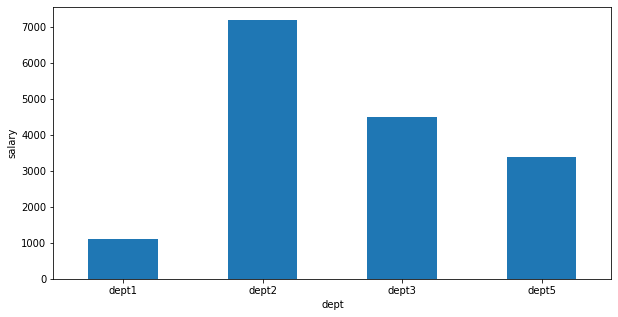

In [ ]:
# Visualize data
ks.options.plotting.backend = 'matplotlib' # Set matplotlib as default visualization library. Default is plotly

kdf_null.groupby('dept').salary.median().plot.bar(figsize=(10, 5))
plt.ylabel('salary')
plt.xticks(rotation=0)

In [ ]:
# Visualize data
ks.options.plotting.backend = "plotly" 

kdf_null.groupby('dept').salary.median().plot.bar(title="Example Figure", height=500, width=500)

In [ ]:
# Save data as csv using koalas
kdf_null.to_csv('PATH.csv')

# Save data as parquet using koalas
kdf_null.to_parquet('PATH.parquet')

# Save data as ORC using koalas
kdf_null.to_spark_io('PATH.orc', format='orc')

In [ ]:
# Read data from csv using koalas
ks.read_csv('PATH.csv')

# Save data as parquet using koalas
ks.read_parquet('PATH.parquet')

# Save data as ORC using koalas
ks.read_spark_io('PATH.orc', format='orc')